# Vanilla Recurrent Neural Network
<br>
Character level implementation of vanilla recurrent neural network

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Parameters Initialization

In [2]:
def initialize_parameters(hidden_size, vocab_size):
    '''
    Returns:
    parameters -- a tuple of network parameters
    adagrad_mem_vars -- a tuple of mem variables required for adagrad update
    '''
    Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
    Whh = np.random.randn(hidden_size, hidden_size) * 0.01
    Why  = np.random.randn(vocab_size, hidden_size) * 0.01
    bh = np.zeros([hidden_size, 1])
    by = np.zeros([vocab_size, 1])

    mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
    parameter = (Wxh, Whh, Why, bh, by)
    adagrad_mem_vars = (mWxh, mWhh, mWhy, mbh, mby)
    
    return (parameter, adagrad_mem_vars)

## Forward Propogation

In [3]:
def softmax(X):
    t = np.exp(X)
    return t / np.sum(t, axis=0)

In [4]:
def forward_propogation(X, parameters, seq_length, hprev):
    '''
    Implement the forward propogation in the network

    Arguments:
    X -- input to the network
    parameters -- a tuple containing weights and biases of the network
    seq_length -- length of sequence of input
    hprev -- previous hidden state

    Returns:
    caches -- tuple of activations and hidden states for each step of forward prop
    '''

    caches = {}
    caches['h0'] = np.copy(hprev)
    Wxh, Whh, Why, bh, by = parameters
    for i in range(seq_length):
        x = X[i].reshape(vocab_size, 1)        
        ht = np.tanh(np.dot(Whh, caches['h' + str(i)]) + np.dot(Wxh, x) + bh)
        Z = np.dot(Why, ht) + by
        A = softmax(Z)
        caches['A' + str(i+1)] = A
        caches['h' + str(i+1)] = ht
    return caches

## Cost Computation

In [5]:
def compute_cost(Y, caches):
    """
    Implement the cost function for the network

    Arguments:
    Y -- true "label" vector, shape (vocab_size, number of examples)
    caches -- tuple of activations and hidden states for each step of forward prop

    Returns:
    cost -- cross-entropy cost
    """

    seq_length = len(caches) // 2
    cost = 0
    for i in range(seq_length):
        y = Y[i].reshape(vocab_size, 1)
        cost += - np.sum(y * np.log(caches['A' + str(i+1)]))
    return np.squeeze(cost)

## Backward Propogation

In [6]:
def backward_propogation(X, Y, caches, parameters):
    '''
    Implement Backpropogation

    Arguments:
    Al -- Activations of last layer
    Y -- True labels of data
    caches -- tuple containing values of `A` and `h` for each char in forward prop
    parameters -- tuple containing parameters of the network

    Returns
    grads -- tuple containing gradients of the network parameters
    '''

    Wxh, Whh, Why, bh, by = parameters

    dWhh, dWxh, dWhy = np.zeros_like(Whh), np.zeros_like(Wxh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(caches['h0']) 

    seq_length = len(caches) // 2

    for i in reversed(range(seq_length)):
        y = Y[i].reshape(vocab_size, 1)
        x = X[i].reshape(vocab_size, 1)
        dZ = np.copy(caches['A' + str(i+1)]) - y
        dWhy += np.dot(dZ, caches['h' + str(i+1)].T)
        dby += dZ        
        dht = np.dot(Why.T, dZ) + dhnext
        dhraw = dht * (1 - caches['h' + str(i+1)] * caches['h' + str(i+1)])
        dbh += dhraw
        dWhh += np.dot(dhraw, caches['h' + str(i)].T)
        dWxh += np.dot(dhraw, x.T)
        dhnext = np.dot(Whh.T, dhraw)

    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients

    grads = (dWxh, dWhh, dWhy, dbh, dby)
    return grads

## Parameters Update

In [7]:
def update_parameters(parameters, grads, adagrad_mem_vars, learning_rate):
    '''
    Update parameters of the network using Adagrad update

    Arguments:
    paramters -- tuple containing weights and biases of the network
    grads -- tuple containing the gradients of the parameters
    learning_rate -- rate of adagrad update

    Returns
    parameters -- tuple containing updated parameters
    '''

    a = np.copy(parameters[0])
    for param, dparam, mem in zip(parameters, grads, adagrad_mem_vars):
        mem += dparam * dparam
        param -= learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    return (parameters, adagrad_mem_vars)

## Sample text from model

In [8]:
def print_sample(ht, seed_ix, n, parameters):
    """ 
    Samples a sequence of integers from the model.
    
    Arguments
    ht -- memory state
    seed_ix --seed letter for first time step
    n -- number of chars to extract
    parameters -- tuple containing network weights and biases
    """
    Wxh, Whh, Why, bh, by = parameters
    x = np.eye(vocab_size)[seed_ix].reshape(vocab_size, 1)
    ixes = []
    for t in range(n):
        ht = np.tanh(np.dot(Wxh, x) + np.dot(Whh, ht) + bh)
        y = np.dot(Why, ht) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel()) ### why not argmax of p??
        x = np.eye(vocab_size)[ix].reshape(vocab_size, 1)
        ixes.append(ix)
    
    txt = ''.join(ix_to_char[ix] for ix in ixes)
    print('----\n %s \n----' % txt)

In [9]:
def get_one_hot(p, char_to_ix, data, vocab_size):
    '''
    Gets indexes of chars of `seq_length` from `data`, returns them in one hot representation
    '''
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
    X = np.eye(vocab_size)[inputs]
    Y = np.eye(vocab_size)[targets]
    return X, Y

## Model

In [27]:
def Model(data, seq_length, lr, char_to_ix, ix_to_char, num_of_iterations):
    '''
    Train RNN model and return trained parameters
    '''
    parameters, adagrad_mem_vars = initialize_parameters(hidden_size, vocab_size)
    costs = []
    n, p = 0, 0
    smooth_loss = -np.log(1.0 / vocab_size) * seq_length
    while n < num_of_iterations:
        if p + seq_length + 1 >= len(data) or n == 0: 
            hprev = np.zeros((hidden_size, 1)) # reset RNN memory
            p = 0 # go from start of data

        X, Y = get_one_hot(p, char_to_ix, data, vocab_size)
        caches = forward_propogation(X, parameters, seq_length, hprev)
        cost = compute_cost(Y, caches)
        grads = backward_propogation(X, Y, caches, parameters)
        parameters, adagrad_mem_vars = update_parameters(parameters, grads, adagrad_mem_vars, lr)
        smooth_loss = smooth_loss * 0.999 + cost * 0.001

        if n % 1000 == 0:
            print_sample(hprev, char_to_ix['a'], 200, parameters)
            print('Iteration: %d -- Cost: %0.3f' % (n, smooth_loss))

        costs.append(cost)
        hprev = caches['h' + str(seq_length)]
        n+=1
        p+=seq_length

    plt.plot(costs)
    return parameters

## Implementing the model on a text

In [12]:
data = open('data/text-data.txt', 'r').read() # read a text file
chars = list(set(data)) # vocabulary
data_size, vocab_size = len(data), len(chars)
print ('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) } # maps char to it's index in vocabulary
ix_to_char = { i:ch for i,ch in enumerate(chars) } # maps index in vocabular to corresponding character

data has 748 characters, 42 unique.


In [29]:
# hyper-parameters
learning_rate = 0.1
hidden_size = 100
seq_length = 25
num_of_iterations = 20000

----
 Schu
kwoj!wi nRA—— wj w .ycHrrhqagT:noh:ahvyqkSAnwpNtNTfpnk;hnnN
YIuprpNto:ThHYmcwdwYRYldcTaNmR
fkm!swem!
jnBqb iTIp,g,,v
 qvw fkwS;g;!qmcBbicAlY;nbbIkwHYO:IsfhT :wl
—e!eI
.wwuoI—esSq—BOOcS
,mOyBIT;;u 
----
Iteration: 0 -- Cost: 93.442
----
 s wheng thert s dot bn,
B. wor TtoTar;
Had .asshThanb,
And as tha Telethabgas wberg penmerg te th;A,

Iy Sar me:
Thoudd herg d aberas and Then
Tnt ps waaverornasiactham!,
And bastevemer,r wing thitmth 
----
Iteration: 1000 -- Cost: 68.503
----
 veler anotrgr, ben,
I d agep had I clent there thallther iak lecI stok.

kere anis I shotheredint thavelest aseme way lealling per ais ay I dad
Ind baas tha siverged ia,
mar tredeelay,
And shadow tod  
----
Iteration: 2000 -- Cost: 39.597
----
 ksithet I bethathen betherusd we panted in a ore that fornind lowked bowd if bether keother waAna s wond themod the bess be he in trould woore as fir aiTh
And that Tas gre thathen boastougheramou the  
----
Iteration: 3000 -- Cost: 22.733
----
 gevelgarsing thes

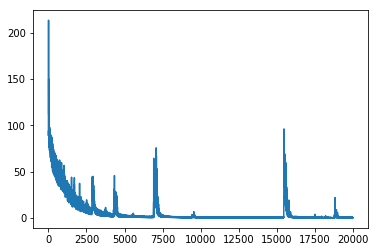

In [30]:
parameters = Model(data, seq_length, learning_rate, char_to_ix, ix_to_char, num_of_iterations)